In [1]:
# ARIMA
'''
Autoregressive Integrated Moving Average의 약자로,
Autoregressive는 자기 회귀모형을 의미하고,
Moving Average는 이동평균모형을 의미한다

ARIMA는 자기회귀와 이동평군을 둘 다 고려하는 모형인데,
ARMA와 ARIMA의 차이점은 ARIMA의 경우 시계열의 비정상성(Non-stationary)을
설명하기 위해 관측치 간의 차분(Diffrance)을 사용한다는 것이다

* 정상성(Stationary) : 시간에 따른 평균, 분산, 특정 시차 간의 공분산이 시간에 따라 변하지 않는 경우

AR : 자기회귀(Autoregression). 현재의 데이터를 과거의 데이터의 선형 결합으로 설명한다
     오늘의 값은 어제의 값 자체에 영향을 받는다. 만약 계수가 양수이면 어제의 값이 큰 값이면
     오늘의 값도 큰 값을 가지며, 음수이면 어제의 값이 큰 값이면 오늘의 값은 작은 값이 된다
     기본 AR(1)식 -> X(t) = (theta)*X(t-1)+epsilon(t)
     theta는 자기상관계수, epsilon은 백색소음(white noise), Time lag는 1이상
     
I : Integrated. 누적을 의미하는 것으로, 차분을 이용하는 시계열모형들에 붙이는
    표현이다. 차분은 정상 시계열이 아닌 데이터를 정상화시키는 방법 중 하나이다
    1차 차분은 단순히 현재 시간과 그 전 시간의 차이다(즉, 속도 개념).
    예를 들어 추세가 있어 증가 혹은 감소가 있는 시계열은 정상성이지 않지만 그 증가 속도, 감소 속도가
    일정하다면 1차 차분을 통해서 정상화시킬 수 있다. 2차 차분은 속도와 속도의 차이이므로
    가속도 정도로 생각할 수 있다
    
MA : 이동평균(Moving Average). 현재의 데이터를 과거 데이터의 오차항의 선형 결합으로 설명한다
     오늘의 값은 어제의 값의 오차항에 영향을 받는다. 계수가 양수이면, 어제의 값이 상승하는 추세이면,
     오늘의 값도 상승하는 추세이다. 반대로 음수이면, 어제의 값이 상승하는 추세이면,
     오늘의 값은 하강한다
     기본 MA(1)식 -> X(t) = epsilon(t) - beta(1)*epsilon(t-1)
     epsilon은 t시점의 오차항, beta는 이동평균계수

현실에 존재하는 시계열자료는 불안정(Non-stationary)한 경우가 많다
그런데 AR(p), MA(q) 모형이나, 이 둘을 합한 ARMA(p,q)모형으로는
이러한 불안정성을 설명할 수 없다
따라서 모형 그 자체에 이러한 비정상성을 제거하는 과정을 포함한 것이
ARIMA모형이며 ARIMA(p, d, q)로 표현한다

AR(p) = ARIMA(p, 0, 0)
MA(q) = ARIMA(0, 0, q)
ARMA(p,q) = ARIMA(p, 0, q)
'''
print()

In [19]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [25]:
samsung = pd.read_csv('samsung.csv')
samsung = samsung[::-1]
samsung = samsung.drop(['시가','고가','저가','거래량'], axis=1)
samsung['종가'] = samsung['종가'].map(lambda x: int(re.sub(r',', '', x)))
test = samsung.iloc[-20:, :]
samsung = samsung.iloc[-120:-20, :]
test.reset_index(drop=True, inplace=True)
samsung.reset_index(drop=True, inplace=True)
samsung.columns = ['date', 'close']
test.columns = ['date', 'close']
samsung
test

,date,close
0,2020-08-06,58000
1,2020-08-07,57500
2,2020-08-10,57800
3,2020-08-11,58200
4,2020-08-12,59000
5,2020-08-13,58700
6,2020-08-14,58000
7,2020-08-18,58400
8,2020-08-19,57800
9,2020-08-20,55400


In [26]:
samsung['date'] = pd.to_datetime(samsung.date, format='%Y-%m-%d')
samsung = samsung.set_index('date')
print(samsung.info())

test['date'] = pd.to_datetime(test.date, format='%Y-%m-%d')
test = test.set_index('date')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2020-03-13 to 2020-08-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   100 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
None


<AxesSubplot:xlabel='date'>

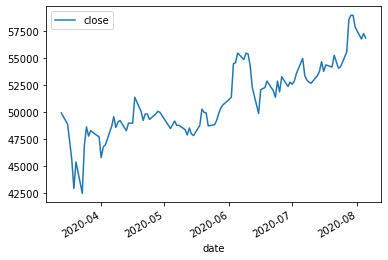

In [5]:
samsung.plot()

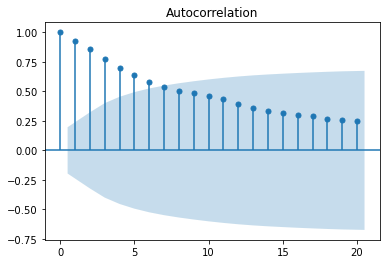

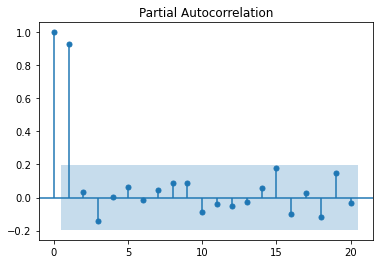

In [6]:
# ARIMA hyperparameter
'''
ARIMA의 hyperparameter는 크게 3가지이다
AR모형의 Lag를 의미하는 p, MA모형의 Lag를 의미하는 q,
차분(Diffrence) 횟수를 의미하는 d
보통 p,d,q 순서로 쓰며, 통상적으로 p+q<2, p*q=0인 값들을 많이 사용한다

여기서 p*q=0이라 하면, 두 값 중 하나는 0이라는 것인데,
ARIMA는 AR모형과 MA모형을 하나로 합친 것이지만 실제로 대부분의 시계열
자료에서는 하나의 경향만을 강하게 띄기 때문에 이렇게 사용하는 것이
더 잘 맞는다고 한다

p,d,q를 정하는 방법
-> 경험적으로 찾을 수 있지만, ACF plot과 PACF plot을 이용해서
   AR과 MA의 모수를 추정할 수 있다
-> ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을
   측정하는 함수
-> PACF(Parial autocorrelation function) : k 이외의 모든 다른 시점 관측치의
   영향력을 배제하고 y(t)와 y(t-k) 두 관측치의 관련성을 측정하는 함수
시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고
PACF는 처음 시차를 제외하고 급격히 감소한다.
반대로 MA의 특성을 띄는 경우, ACF는 급격히 감소하고 PACF는 천천히 감소한다
급격히 감소하는 시차를 각 AR과 MA모형의 모수(p,q)로 사용할 수 있다
또한, 데이터를 차분하여 ACF 및 PACF를 계산함으로써 적절한 차분횟수까지
구할 수 있다
'''
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(samsung) # ACF plot
plot_pacf(samsung) # PACF plot
plt.show()

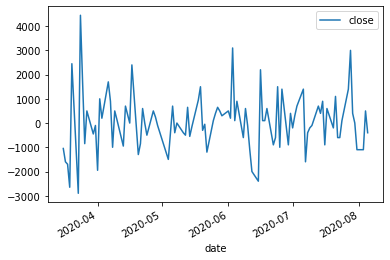

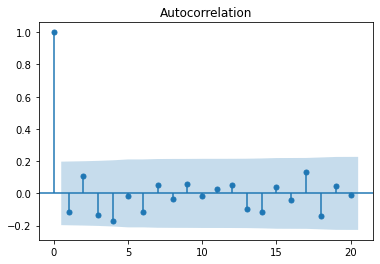

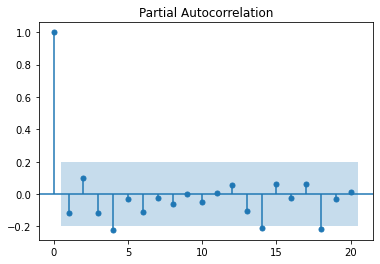

In [7]:
'''
ACF를 보면 12.5의 Time lag를 기준으로 자기상관이 양에서 음으로 변동한다
PACF는 약 1의 Time lag에서 약 0.9를 보이고 이후에 급격히 감소한다
따라서 p=0, q=1이 적당하다고 추측할 수 있다

적절한 차분 차수의 계산을 위해 우선 1차 차분을 하고, ACF와 PACF를 다시 계산한다
'''
diff_1 = samsung.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [8]:
# ADF(Augmented Dickey-Fuller) 검정
'''
ARIMA 모형의 적분 차수를 판단하기 위한 검정 방법의 하나이다
1차 누적에 의한 확률적 추세뿐 아니라 2차항으로 나타나는 결정론적 추세를 포함하는 시계열에 대해서
Dickey-Fuller 단위근 검정(unit root test)을 할 수 있도록 DF 검정을 일반화 한 것

input
x : 시계열 자료 / maxlag : ADF 검정에 사용할 시차의 수(default = 12*(nobs/100)^(1/4))
regression : 검정에 사용할 모형
-> 'nc' : 결정론적 추세 없음(=DF검정)
-> 'c' : 상수항만 사용
-> 'ct' : 상수항과 1차 추세 사용
-> 'ctt' : 상수항과 1차 추세, 2차 추세 사용
autolag : 검정 AR 모형의 차수를 자동 결정하는 알고리즘 {'AIC', 'BIC', 't-stat', None}

output
adf : 검정 통계량 / p-value : MacKinnon(1994) 방식을 사용한 p-value 추정치
usedlag : 사용된 시차의 수 / nobs : 분석 자료의 수
critical values : 1%, 5%, 10% 수준에 해당되는 검정 통계량의 값
'''
from statsmodels.tsa.stattools import adfuller
y = samsung['close']
y_1diff = samsung.diff().dropna()['close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -1.3880
원 데이터 p-value :  0.5880
1차 차분 ADF Statistic : -7.5032
1차 차분 p-value :  0.0000


In [20]:
'''
차분 이후의 ACF와 PACF를 보니, 시계열이 정상상태(Stationary)를 보이는 것으로
생각되므로, 1차 차분만으로 충분할 것으로 판단된다
따라서 본 데이터는 ARIMA(0,1,1)을 사용한다

fit 파라미터
-> trend : 상수 포함 여부
   'nc':상수 미포함 / 'c':상수 포함
'''
model = ARIMA(samsung, order=(0,1,1)) # freq='D'
model_fit = model.fit(trend='c')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                   99
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -841.031
Method:                       css-mle   S.D. of innovations           1183.554
Date:                Wed, 09 Sep 2020   AIC                           1688.063
Time:                        16:06:25   BIC                           1695.848
Sample:                             1   HQIC                          1691.213
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            71.9241    107.290      0.670      0.503    -138.361     282.210
ma.L1.D.close    -0.0992      0.095     -1.045      0.296      -0.285       0.087
                                    Root

In [21]:
'''
'P>z'값이 일반적으로 학습의 적정성을 위해 확인하는 t-test값이다
즉, p-value 0.05 수준에서 보면 MA(1)의 계수와 모형의 Constant는 유효하지 않다
따라서, 위 코드에서 model.fit()의 파라미터 중 trend='c'가 아니라 'nc'로
설정해주어야 한다
'''
model = ARIMA(samsung, order=(0,1,1)) # freq='D'
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                   99
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -841.254
Method:                       css-mle   S.D. of innovations           1186.227
Date:                Wed, 09 Sep 2020   AIC                           1686.508
Time:                        16:06:27   BIC                           1691.698
Sample:                             1   HQIC                          1688.608
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ma.L1.D.close    -0.0937      0.094     -0.998      0.318      -0.278       0.090
                                    Roots                                    
                  Real          Imaginary   

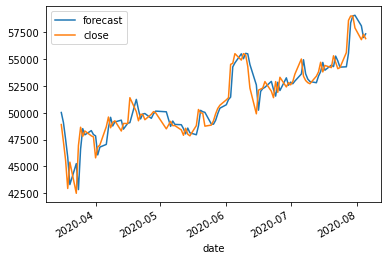

In [35]:
model_fit.plot_predict()
plt.show()

In [22]:
# AIC를 기준으로 최적의 차수 찾기
'''
AIC(Akaike's Information Criterion)
-> 낮을수록 좋은 모델이다
-> 여러 통계 모델들의 성능을 비교할 수 있게 해준다
-> AIC = -2(log-likelihood) + 2k
   k : 모형 파라미터의 개수 / log-likelihood : 모형 적합도를 나타내는 척도

BIC(Bayesian's Information Criterion)
-> 낮을수록 좋은 모델이다
-> BIC = -2(log-likelihood) + K(log-n)
   K : 전체 모수의 수 / n : 데이터 포인트의 수
'''
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(samsung, [3,3,3])
result

,order,AIC
7,p0 d2 q1,1677.334068
16,p1 d2 q1,1678.146010
8,p0 d2 q2,1678.343432
25,p2 d2 q1,1679.024247
17,p1 d2 q2,1679.324182
26,p2 d2 q2,1680.787569
13,p1 d1 q1,1681.681097
23,p2 d1 q2,1683.484169
22,p2 d1 q1,1683.671156
3,p0 d1 q0,1687.178040


In [36]:
model = ARIMA(samsung, order=(0,2,1)) # freq='D'
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                   98
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -835.667
Method:                       css-mle   S.D. of innovations           1193.775
Date:                Wed, 09 Sep 2020   AIC                           1677.334
Time:                        17:48:54   BIC                           1685.089
Sample:                             2   HQIC                          1680.471
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.7632      4.198      0.658      0.510      -5.465      10.992
ma.L1.D2.close    -0.9999      0.027    -36.910      0.000      -1.053      -0.947
                                    

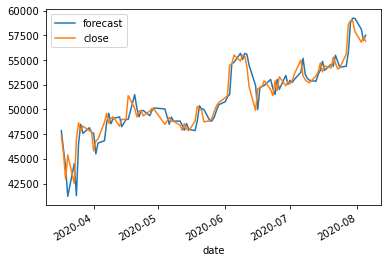

In [28]:
# prediction
'''
모델의 예측값이 단순히 실제값을 shifting 해놓은 것과 거의 같은 모형을 나타낸다
이는 모델이 실제의 값(과거)을 바탕으로 바로 다음의 값(현재)을 에측하는데, 거의 전의 값을 그대로
사용하는게 그나마 실측치와 비슷한 결과를 만든다고 모델이 추론한 것이다
'''
model_fit.plot_predict()
plt.show()

In [14]:
pred = model_fit.forecast(steps=1)
print(pred)
# predict_value, stderr, upper bound, lower bound

(array([56974.99263275]), array([1196.366858]), array([[54630.15667878, 59319.82858672]]))


In [15]:
preds = model_fit.forecast(steps=20)
print(preds[:][0])

[56974.99263275 57049.9852655  57124.97789825 57199.970531
 57274.96316375 57349.9557965  57424.94842926 57499.94106201
 57574.93369476 57649.92632751 57724.91896026 57799.91159301
 57874.90422576 57949.89685851 58024.88949126 58099.88212401
 58174.87475676 58249.86738951 58324.86002227 58399.85265502]


Text(0.5, 1.0, 'samsung stock predict')

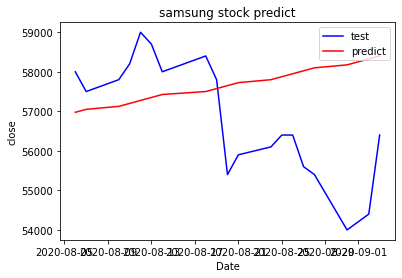

In [16]:
plt.plot(test.index, test['close'], 'b', label='test')
plt.plot(test.index, preds[:][0], 'r', label='predict')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('close')
plt.title('samsung stock predict')

In [17]:
'''
최근 딥러닝, 인공지능 등의 트렌드와 함께 시계열분석에도 인공신경망이 널리
사용되고 있다
특히 시계열분석에는 RNN, LSTM 등을 이용할 수 있지만, 신경망 모델의 가장 큰
단점은 아직 제대로 된 모형 해석이 거의 안된다는 점이다
알고리즘적인 측면에서야 성능이 잘 나오면 되는거지만 데이터과학, 특히 의사결정
지원 시스템(Decision support system)에서는 최종 결정권자는 사람이기에 모형이
그렇게 예측한 근거가 필요하다
이러한 관점에서 보았을 때, AR, MA등과 같은 고전적인 통계기반의 시계열분석법이
아직은 조금 더 우위에 있지 않나 싶다
'''
print()